In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

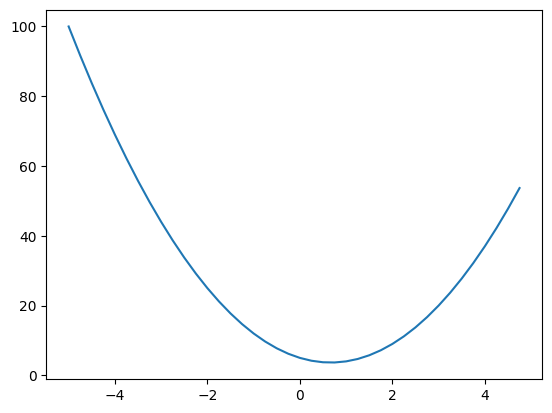

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [13]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [ ]:
# les get more complex

# inputs
a = 2.0
b = -3.0
c = 10

d = a*b + c

print('d', d)


d 4.0


In [19]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [199]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
            
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self,), _op='exp')
        
        def _backward():
            self.grad +=  out.data * out.grad
            
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        out = Value(self.data**other, _children=(self,), _op=f'**{other}')
        
        def _backward():
            self.grad += (other) * ((self.data)**(other-1 )) * out.grad
            
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op='tanh')
        
        def _backward():
            self.grad  += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [200]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR: left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ('record') node for it
        dot.node(name=uid, label=" %s | {data %.4f} | {grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name= uid + n._op, label= n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 node to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [202]:
# building neurons
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# eqn : x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.grad = 1.0

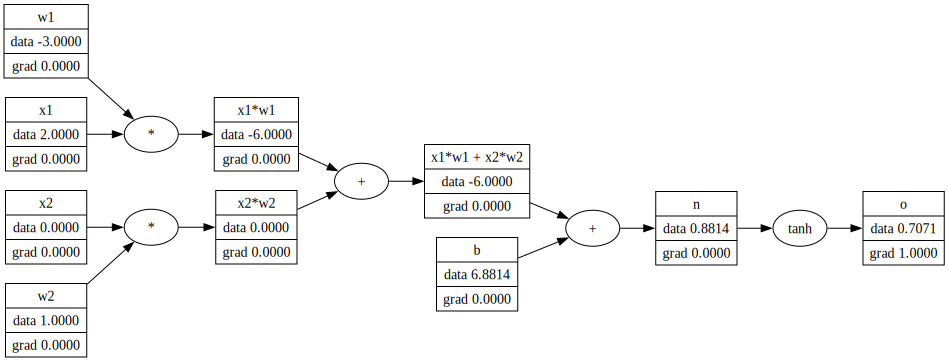

In [203]:
draw_dot(o)

In [206]:
# building neurons
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# eqn : x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o'
o.grad = 1.0
o.backward()

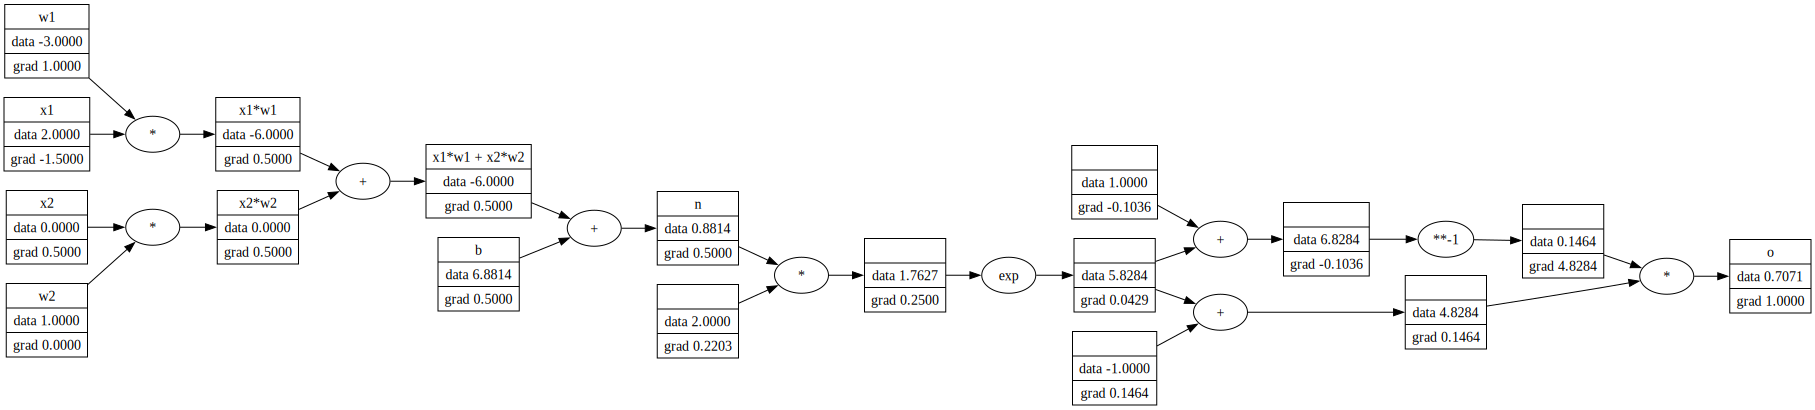

In [207]:
draw_dot(o)

## Pytorch Validation

In [208]:
import torch

In [214]:
x1 = torch.Tensor([2.0]).double()                           ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                           ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                          ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                           ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()             ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print(o.data)
print(o.data.item())

o.backward()
print("------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
tensor([0.7071], dtype=torch.float64)
0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [255]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        n_params = [n.parameters() for n in self.neurons]
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.3170019127403518)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=0.3170019127403518),
 Value(data=-0.19344453886616492),
 Value(data=-0.6667211790895731),
 Value(data=-0.07448031539122982)]

In [ ]:
ypred = [n(x) for x in xs]
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.9161144325154948)

In [314]:
ypred = [n(x) for x in xs]
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0007160619115186948)

In [312]:
loss.backward()

In [313]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [315]:
ypred

[Value(data=0.9990985194391534),
 Value(data=-0.9734054661082957),
 Value(data=-0.9971630641216584),
 Value(data=0.9991371712662036)]